In [10]:
import numpy as np 
import pandas as pd
import os
import zipfile
import cv2
from matplotlib import pyplot as plt
import shutil 
from tqdm import tqdm
import torch
import torchvision
import time
import copy
from torchvision import transforms, models

In [11]:
print(os.listdir('../input'),'\n') 
with zipfile.ZipFile('../input/platesv2/plates.zip', 'r') as zip_obj:
        zip_obj.extractall('/kaggle/working/') 
print(os.listdir('/kaggle/working/'))

data_root = '/kaggle/working/plates/' 
print(data_root)
print(os.listdir(data_root))

['platesv2'] 

['plates', 'train', 'val', '__MACOSX']
/kaggle/working/plates/
['test', 'train', '.DS_Store']


In [12]:
class Remove_background_and_crop:
    
    def __init__(self,img):
        self.x00 = 0
        self.x00 = 0
        self.r00 = 0
        self.img = img
        self.mask = img
                
    def crop (self): 
            c_r_crop = (1.42*self.r00/2)
            self.img = self.img[int(self.y00)-int(c_r_crop):int(self.y00)+int(c_r_crop),int(self.x00)-int(c_r_crop):int(self.x00)+int(c_r_crop)]
            self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
            crop = self.img
            cv2.imwrite(image_folder,crop)
            h,w = self.img.shape[:2] 
            c = min(h,w)     
            for i in range (5,int(c/3),5): 
                    crop_img = self.img[i:h-i,i:w-i]    
                    cv2.imwrite(image_folder[:-4] +  '_Crop_' + str(i) + '.jpg',crop_img)
            image1 = self.img[0:int(h//2),0:int(w//2)]
            #Делим изображение на 4 части
            cv2.imwrite(image_folder[:-4] +  'image1' + '.jpg',image1)
            image2 = self.img[int(h//2):h,int(w//2):w]
            cv2.imwrite(image_folder[:-4] +  'image2' + '.jpg',image2)
            image3 = self.img[int(h//2):h,0:int(w//2)]
            cv2.imwrite(image_folder[:-4] +  'image3' + '.jpg',image3)
            image4 = self.img[0:int(h//2),int(w//2):w]
            cv2.imwrite(image_folder[:-4] +  'image4' + '.jpg',image4)
            
    def crop_test (self):
        c_r_crop = (1.42*self.r00/2)
        self.img = self.img[int(self.y00)-int(c_r_crop):int(self.y00)+int(c_r_crop),int(self.x00)-int(c_r_crop):int(self.x00)+int(c_r_crop)]
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(image_folder,self.img)       
            
    def find_circle(self):
        output = self.img.copy()    
        img = cv2.convertScaleAbs(self.img, alpha=1.2, beta=0.0)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 10,param1=10,param2=5,minRadius=40,maxRadius=250)
        
        if circles is not None: 
            
            circles = np.round(circles[0, :]).astype("int")
            
                             
            for x, y, r in circles:
                if ((self.x00-15)<x<(self.x00+15)) and ((self.y00-15)<y<(self.y00+15)):
                    if r > self.r00: 
                        self.x00 = x
                        self.y00 = y
                        self.r00 = r
                        
                    
            if self.r00==0: 
                
                ret,thresh = cv2.threshold(self.mask,235,255,0)
                contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)   
                c = max(contours, key=cv2.contourArea)
                (self.x00, self.y00), self.r00 = cv2.minEnclosingCircle(c)
            
            
    def findCoordinates(self):  
        ret,thresh = cv2.threshold(self.mask,235,255,0)        
        M = cv2.moments(thresh)
        self.x00 = int(M["m10"] / M["m00"])
        self.y00 = int(M["m01"] / M["m00"])
        
    def remove_background(self):  
        mainRectSize = .08
        fgSize = .01
        img = self.img
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        new_h, new_w = img.shape[:2]
        mask = np.zeros(img.shape[:2], np.uint8)
        bg_w = round(new_w * mainRectSize)
        bg_h = round(new_h * mainRectSize)
        bg_rect = (bg_w, bg_h, new_w - bg_w, new_h - bg_h)
        fg_w = round(new_w * (1 - fgSize) / 2)
        fg_h = round(new_h * (1 - fgSize) / 2)
        fg_rect = (fg_w, fg_h, new_w - fg_w, new_h - fg_h)
        cv2.rectangle(mask, fg_rect[:2], fg_rect[2:4], color=cv2.GC_FGD, thickness=-1)
        bgdModel1 = np.zeros((1, 65), np.float64)
        fgdModel1 = np.zeros((1, 65), np.float64)
        cv2.grabCut(img, mask, bg_rect, bgdModel1, fgdModel1, 3, cv2.GC_INIT_WITH_RECT)
        cv2.rectangle(mask, bg_rect[:2], bg_rect[2:4], color=cv2.GC_PR_BGD, thickness=bg_w * 3)
        cv2.grabCut(img, mask, bg_rect, bgdModel1, fgdModel1, 10, cv2.GC_INIT_WITH_MASK)   
        mask_result = np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')
        masked = cv2.bitwise_and(img, img, mask=mask_result)
        masked[mask_result < 2] = [255, 255, 255] 
        self.img = masked
        self.mask = mask_result
    
for image_index in range (20):
    print ("Complete dirty: ","{0:04}".format(image_index),"/0019", end="\r")
    image_folder = '/kaggle/working/plates/train/dirty/{0:04}.jpg'.format(image_index) 
    img = cv2.imread(image_folder)
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop()    
print ("\n\r", end="")    
    
for image_index in range (20):
    print ("Complete cleaned: ","{0:04}".format(image_index),"/0019", end="\r")
    image_folder = '/kaggle/working/plates/train/cleaned/{0:04}.jpg'.format(image_index) 
    img = cv2.imread(image_folder)
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop()
print ("\n\r", end="")

for image_index in range (744):
    print ("Complete test: ","{0:04}".format(image_index),"/0743", end="\r")
    image_folder = '/kaggle/working/plates/test/{0:04}.jpg'.format(image_index) 
    img = cv2.imread(image_folder)
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop_test()
print ("\n\r", end="") 

Complete dirty:  0019 /0019
Complete cleaned:  0019 /0019
Complete test:  0743 /0743


In [13]:
train_dir = 'train' # на этих данных будем обучать модель
val_dir = 'val' #на этих данных будем смотреть какую accuracy показывает наша модель 
class_names = ['cleaned', 'dirty']
 
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
 
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 281/281 [00:00<00:00, 4952.47it/s]


In [14]:
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.09, p=0.75, interpolation=3, fill=255),
    transforms.Resize((224, 224)),    
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Транформация нормировки. Изображения привести к виду, на котором обучался изначальный ResNet. Вычетаем от красного, зелёного и синего константы 0.485, 0.456, 0.406 и делим на 0.229, 0.224, 0.225 (данные из мануала ResNet)
])

val_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),     
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Транформация нормировки. Изображения привести к виду, на котором обучался изначальный ResNet. Вычетаем от красного, зелёного и синего константы 0.485, 0.456, 0.406 и делим на 0.229, 0.224, 0.225 (данные из мануала ResNet)
])   

dataset_transforms = {
                      'orig': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),

                      '140': transforms.Compose([
    transforms.CenterCrop(140),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '135': transforms.Compose([
    transforms.CenterCrop(135),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]), 
                      '130': transforms.Compose([
    transforms.CenterCrop(130),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '125': transforms.Compose([
    transforms.CenterCrop(125),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '120': transforms.Compose([
    transforms.CenterCrop(120),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '115': transforms.Compose([
    transforms.CenterCrop(115),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '110': transforms.Compose([
    transforms.CenterCrop(110),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '105': transforms.Compose([
    transforms.CenterCrop(105),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '100': transforms.Compose([
    transforms.CenterCrop(100),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '95': transforms.Compose([
    transforms.CenterCrop(95),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '90': transforms.Compose([
    transforms.CenterCrop(90),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '85': transforms.Compose([
    transforms.CenterCrop(85),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '80': transforms.Compose([
    transforms.CenterCrop(80),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '75': transforms.Compose([
    transforms.CenterCrop(75),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),                                         
                       '70': transforms.Compose([
    transforms.CenterCrop(70),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),                                                           
                     }
 
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 16 # Количество изображений в батче
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

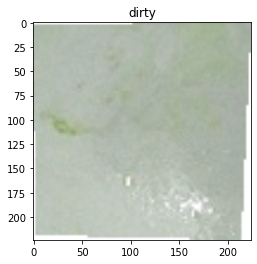

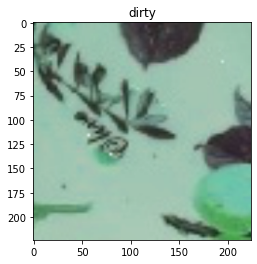

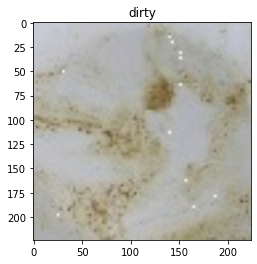

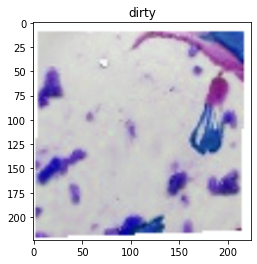

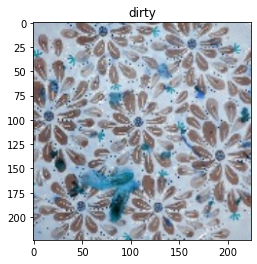

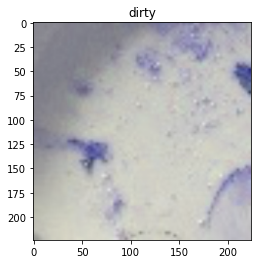

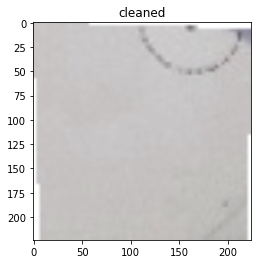

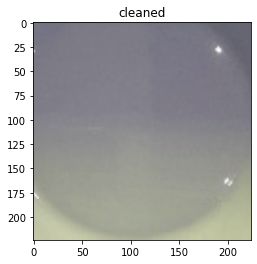

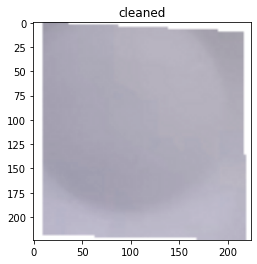

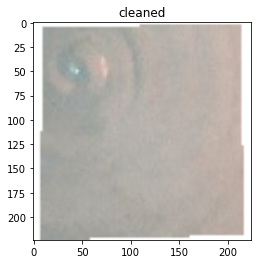

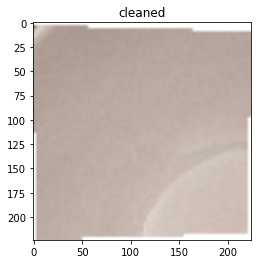

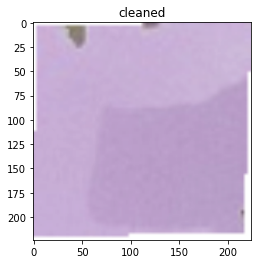

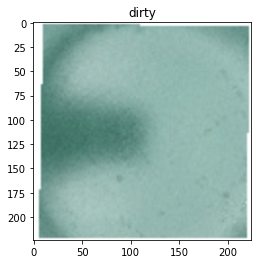

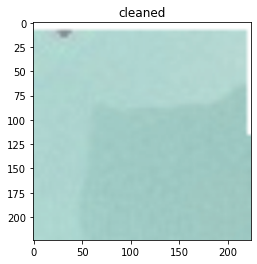

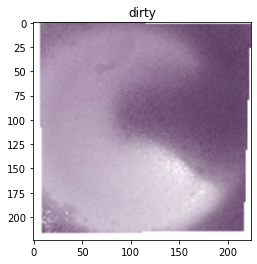

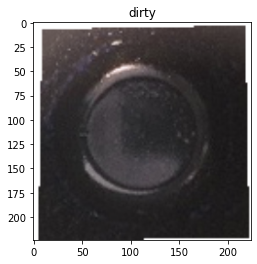

In [15]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy() #обратная операция к ToTensor - .permute(1, 2, 0) Channels,H,W -> H,W,Channels потом превращаем в numpy array .numpy()
    image = std * image + mean #Делаем обратную трансформацию нормировки
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.1)
 
X_batch, y_batch = next(iter(train_dataloader)) 
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [16]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
 
    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}
 
    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch, num_epochs - 1), end="")
        for phase in ['train', 'val']:
            if phase == 'train': #Если фаза == Тренировки  
                dataloader = train_dataloader #берем train_dataLoader
                scheduler.step() #Делаем 1 шаг (произошла одна эпоха)
                model.train()  # Модель в training mode - обучение (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
            else: #Если фаза == Валидации 
                dataloader = val_dataloader #берем val_dataLoader 
                model.eval()   # Модель в evaluate mode - валидация (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
 
            running_loss = 0. 
            running_acc = 0.
 
            # Итерируемся по dataloader
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device) # Тензор с изображениями переводим на GPU 
                labels = labels.to(device) # Тензор с лейблами переводим на GPU 
 
                optimizer.zero_grad() # Обнуляем градиент,чтобы он не накапливался 
 
                with torch.set_grad_enabled(phase == 'train'): #Если фаза train то активируем все градиенты (те которые не заморожены) (очистить историю loss)
                    preds = model(inputs) # Считаем предикты, input передаем в модель
                    loss_value = loss(preds, labels) #Посчитали  Loss    
                    preds_class = preds.argmax(dim=1) # Получаем класс,берем .argmax(dim=1) нейрон с максимальной активацией
                
                    if phase == 'train':
                        loss_value.backward() # Считаем градиент 
                        optimizer.step() # Считаем шаг градиентного спуска
 
                # Статистика
                running_loss += loss_value.item() #считаем Loss
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()  #считаем accuracy
 
            epoch_loss = running_loss / len(dataloader)  # Loss'ы делим на кол-во бачей в эпохе 
            epoch_acc = running_acc / len(dataloader) #считаем Loss на кол-во бачей в эпохе
 
            print("{} Loss: {:.4f} Acc: {:.4f} ".format(phase, epoch_loss, epoch_acc), end="")
            
            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)
        
    return model, loss_hist, acc_hist

In [17]:
model = models.resnet152(pretrained=True) #Формат pretrained=True - нам нужны веса, которые получились вследствие обучения этого ResNet, на датасете ImageNet
          
# Замораживаем веса, чтобы не использовать лишние веса в обучении, а обучать только последний слой
for param in model.parameters(): #Проходим по параметрам модели (каждый параметр - это каждый слой, model.parameters нам отдаст некоторый итератор по слоям)
    param.requires_grad = False #Для каждого параметра и слоя:"requires grad = False", то есть уже не требуется вычисление градиента для данного слоя. И получается, что у нас вся сетка будет заморожена, то есть мы не сможем вообще ничего обучать.
    
#Меняем последний полносвязанный слой, в ResNet он классифицирует на тысячу классов, а у нас класса всего 2.
model.fc = torch.nn.Linear(model.fc.in_features, 2) # Cоздадим слой torch.nn.Linear, это полносвязный слой, на вход он принимает model fc_in features. И он единсвенный - разморожен.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
 
#Определяем Loss функцию
#В данном случае - это бинарная кросс-энтропия CrossEntropyLoss (у нас всего 2 класса) 
loss = torch.nn.CrossEntropyLoss()
# Метод градиентного спуска Adam
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.001) #lr - (learning rate - шаг градиентного спуска)
# Уменьшаем шаг градиентного спуска каждые 7 эпох
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


Запускаем обучение

In [18]:
model, loss, acc = train_model(model, loss, optimizer, scheduler, num_epochs=30); #Запуск функции Train (Модель= ResNet,Loss-функция= CrossEntropyLoss(бинарная кросс-энтропия),Метод градиентного спуска= Adam, Уменьшение градиентного спуска в зависимости от кол-ва эпох, Кол-во эпох= 30) )

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 0/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.5988 Acc: 0.6544 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.4135 Acc: 0.8273 Epoch 1/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.4241 Acc: 0.8033 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.3734 Acc: 0.8114 Epoch 2/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.4208 Acc: 0.8051 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.3588 Acc: 0.8398 Epoch 3/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.3395 Acc: 0.8327 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2564 Acc: 0.9250 Epoch 4/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.4804 Acc: 0.7812 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2014 Acc: 0.9193 Epoch 5/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.3396 Acc: 0.8419 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2054 Acc: 0.9193 Epoch 6/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2830 Acc: 0.9081 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2673 Acc: 0.9136 Epoch 7/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2498 Acc: 0.9173 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2630 Acc: 0.9080 Epoch 8/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2860 Acc: 0.8695 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2132 Acc: 0.9364 Epoch 9/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2948 Acc: 0.8842 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2490 Acc: 0.9136 Epoch 10/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2567 Acc: 0.9026 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2465 Acc: 0.9080 Epoch 11/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2742 Acc: 0.8695 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2159 Acc: 0.9307 Epoch 12/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2617 Acc: 0.9007 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2517 Acc: 0.9023 Epoch 13/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2693 Acc: 0.8750 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2385 Acc: 0.9080 Epoch 14/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2621 Acc: 0.8603 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2276 Acc: 0.9250 Epoch 15/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2642 Acc: 0.9007 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.3068 Acc: 0.8852 Epoch 16/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2905 Acc: 0.8621 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2570 Acc: 0.8909 Epoch 17/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2656 Acc: 0.8787 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2319 Acc: 0.8966 Epoch 18/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2566 Acc: 0.9118 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2737 Acc: 0.9080 Epoch 19/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2563 Acc: 0.8897 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2257 Acc: 0.9193 Epoch 20/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2820 Acc: 0.8805 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2164 Acc: 0.9364 Epoch 21/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2906 Acc: 0.8952 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2486 Acc: 0.9023 Epoch 22/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2803 Acc: 0.8897 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2841 Acc: 0.9080 Epoch 23/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2681 Acc: 0.9099 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2317 Acc: 0.9193 Epoch 24/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2241 Acc: 0.9320 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2895 Acc: 0.8966 Epoch 25/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2640 Acc: 0.9099 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2261 Acc: 0.9364 Epoch 26/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2783 Acc: 0.8768 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2621 Acc: 0.8784 Epoch 27/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2620 Acc: 0.8768 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2362 Acc: 0.9250 Epoch 28/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2646 Acc: 0.8768 

  0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.2385 Acc: 0.9080 Epoch 29/29:

  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2826 Acc: 0.8732 

100%|██████████| 11/11 [00:02<00:00,  4.52it/s]

val Loss: 0.2468 Acc: 0.9080 

График Accuracy

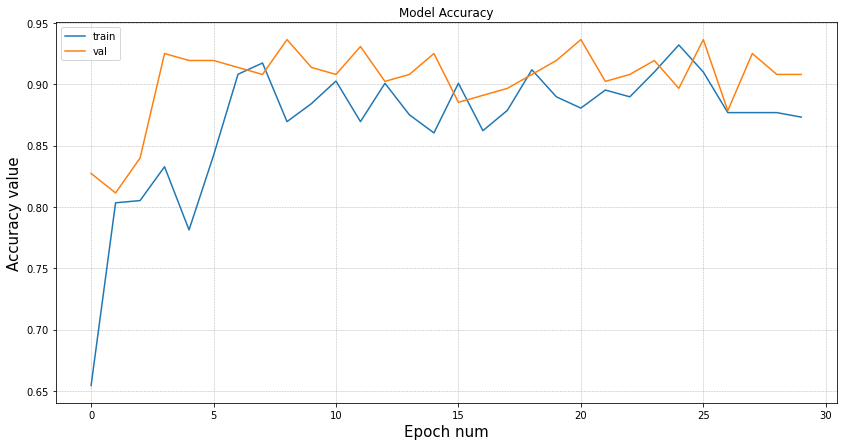

In [19]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

График loss

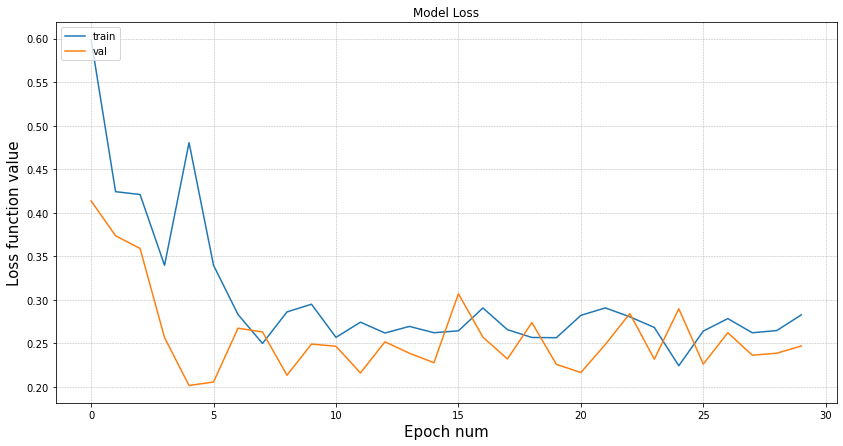

In [20]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss.keys():
    plt.plot(loss[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

In [21]:
#Костыль ImageFolder, который не может обработать путь к папке в которой уже сразу лежат изображения
#Копируем всю папку test в директорию test\unknown
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [22]:
#Мы не знаем, какие ID, какие названия изображения у нас генерируется, когда мы просим у DataLoader -- "дай нам следующий батч".
#Они по алфавиту идут, по дате создания, или просто случайным образом -- непонятно.
#Поэтому нам нужно переписать немножко ImageFolder, чтобы он нам отдавал не просто tuple, с самим изображением и его меткой, а ещё, чтобы он отдавал имя, ну, либо -- путь к изображению.
class ImageFolderWithPaths(torchvision.datasets.ImageFolder): #Создаем класс, он наследуется от ImageFolder, но изменяет его функцию get_item
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index) #Дополняем original_tuple путем для файла (.__getitem__(index))
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
df = pd.DataFrame
#Итерируемся по Crop'ам test датасета
for (i,tranforms) in dataset_transforms.items():
    test_dataset = ImageFolderWithPaths('/kaggle/working/test', tranforms) #Берем новый класс и получаем tuple из 3х значений
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0) #Новый даталоадер с путями до изображений
    
    model.eval() #Переводим модель в состояние eval
    test_predictions = []  #Создаем пустой список предсказания 
    test_img_paths = [] #Пути до изображения
    for inputs, labels, paths in tqdm(test_dataloader): #Цикл по test_dataloader inputs - батч с изображением, lable - тут none, paths - пути до изображения  
        inputs = inputs.to(device) 
        labels = labels.to(device)  
        with torch.set_grad_enabled(False):
            preds = model(inputs) # Считаем предикшены
        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()) #С помощью torch.nn.functional.softmax получаем вероятности, для первого класса [:,1], пеереводим тензор в .data, на .cpu(), в numpy 
        test_img_paths.extend(paths)
    test_predictions = np.concatenate(test_predictions)
    
    
    submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
    submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
    submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
    submission_df.set_index('id', inplace=True)
    
    try : df = df.merge(submission_df, how='inner', on='id') #Объединяем в один датафрейм
    except BaseException: # Для первой итерации
        df = submission_df 
    #submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.50 else 'cleaned')
    #submission_df.to_csv('submission_predict_{0}.csv'.format(i))
df.head(8)

100%|██████████| 47/47 [00:05<00:00,  9.39it/s]


,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y
id,,,,,,,,,,,,,,,,
0000,0.989477,0.997211,0.996039,0.997048,0.990924,0.994517,0.991283,0.989149,0.985594,0.991214,0.990102,0.989151,0.991216,0.995672,0.997835,0.996139
0001,0.762939,0.852276,0.828519,0.937117,0.953521,0.971020,0.973897,0.981045,0.937701,0.925542,0.982329,0.979096,0.976213,0.910771,0.926317,0.930533
0002,0.337171,0.363815,0.352142,0.424541,0.657771,0.540385,0.550923,0.814263,0.891278,0.928748,0.853924,0.903117,0.935301,0.927504,0.912907,0.959038
0003,0.968700,0.671018,0.711056,0.968700,0.923967,0.928503,0.906603,0.894684,0.960376,0.941599,0.969041,0.992116,0.989487,0.991857,0.982344,0.988276
0004,0.414171,0.431339,0.491955,0.681005,0.590626,0.592881,0.700026,0.691593,0.624654,0.746108,0.666784,0.805370,0.822459,0.899647,0.970616,0.949625
0005,0.921832,0.305049,0.367677,0.714788,0.932583,0.908972,0.856439,0.827634,0.768802,0.660255,0.456964,0.390378,0.528764,0.751086,0.799979,0.901464
0006,0.915766,0.905588,0.776088,0.752418,0.863178,0.857097,0.890302,0.956519,0.947562,0.977350,0.984984,0.992348,0.992636,0.987856,0.984449,0.988738
0007,0.797888,0.772597,0.907779,0.896022,0.902914,0.938521,0.939702,0.959017,0.941187,0.897265,0.878844,0.824570,0.772394,0.817990,0.939950,0.960415


Среднее

In [23]:
df['mean'] = df.mean(axis=1)
df.drop(df.columns[:-1], axis='columns', inplace=True)
df['label'] = df['mean'].map(lambda pred: 'dirty' if pred > 0.50 else 'cleaned')
df.drop(df.columns[:-1], axis='columns', inplace=True)
df.head(10)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty
0006,dirty
0007,dirty
0008,dirty


Сохраняем

In [24]:
df.to_csv('submission.csv')